In [2]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import random
from nltk.probability import FreqDist
from sklearn.model_selection import KFold
import pprint, time
import zipfile
# nltk.download("brown")
# nltk.download("universal_tagset")

In [3]:
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# zip_ref = zipfile.ZipFile("./glove.6B.zip",'r') 
# zip_ref.extractall("./")
# zip_ref.close()

In [3]:
f = open('glove.6B.50d.txt')
embed_index = {}
for line in f:
    val = line.split()
    embed_index[val[0]] = np.asarray(val[1:],dtype='float')


In [4]:
def get_glove_embed(w):
    ret = embed_index.get(w)
    if ret is not None:
        return ret 
    return np.zeros((50))

### Implementing HMM Model Class

In [44]:
a = pd.DataFrame({"A":[1,2],"B":[2,3],"C":[4,5]},index=["N","P"])
b = pd.DataFrame({"A":[.2,.5],"B":[.1,.6],"C":[.3,.4]})
c = a.dot(b.T)
d = c.dot(b["A"])
b["A"]

0    0.2
1    0.5
Name: A, dtype: float64

In [65]:
from collections import defaultdict

class HMM:
    
    def __init__(self, train):
#         self.p = 1/len(vocab)
#         self.vocab = vocab
        self.startfreq = pd.Series(FreqDist(sent[0][1] for sent in train))
        self.endfreq = pd.Series(FreqDist(sent[-1][1] for sent in train))
        self.train_set = [(tup[0].lower(),tup[1]) for sent in train for tup in sent]
    
    def calctag(self):
        '''
        Generating Frequency Distribution of Bigrams
        '''
        big = nltk.bigrams(self.train_set)
        temp = FreqDist((a[1], b[1]) for a,b in big)
        #Laplace Smoothing count + 1
        d = {t:[temp[(i,t)]+1 for i in self.tag.index] for t in self.tag.index}
        self.transitions = pd.DataFrame(d,index=self.tag.index)
        self.transitions = self.transitions.divide(self.transitions.sum(axis=1), axis=0)
        
    def calcword(self):
        
        '''
        Probabilities of words
        '''
        
        temp = FreqDist(a for a in self.train_set)
        d = {w:[temp[(w,t)] for t in self.tag.index] for w in self.vocab}
        self.emission = pd.DataFrame(d,index=self.tag.index)
        self.emission = self.emission.divide(self.emission.sum(axis=1), axis=0)
        wordVec = {w:get_glove_embed(w) for w in self.vocab}
        wordVec = pd.DataFrame(wordVec)
#         print(wordVec.shape, self.emission.shape)
        self.tag_embed = self.emission.dot(wordVec.T)
#         self.wordVec = wordVec
        
        '''
        Probabilities of prefix and suffix for a tag for unknown words
        
        
        temp = FreqDist((x[:2],y) for x,y in self.train_set)
        prefixes = {x for x,y in temp}
        d = {w:[temp[(w,t)] for t in self.tag.index] for w in prefixes}
        self.pref = pd.DataFrame(d,index=self.tag.index)
        self.pref = self.pref.divide(self.pref.sum(axis=1), axis=0)
        
        temp = FreqDist((x[-2:],y) for x,y in self.train_set)
        suffixes = {x for x,y in temp}
        d = {w:[temp[(w,t)] for t in self.tag.index] for w in suffixes}
        self.suf = pd.DataFrame(d,index=self.tag.index)
        self.suf = self.suf.divide(self.suf.sum(axis=1), axis=0)
        '''
    
    def word_prob(self, w):
        
        '''
        If word does not exist in vocabulary
        Check for its prefixes and sufixes
        '''
        if w in self.emission:
            return self.emission[w]
        wordP = np.exp(self.tag_embed.dot(get_glove_embed(w)))
        wordP = wordP.divide(wordP.sum())

        return wordP
    
    def viterbi(self, sent):
    
        stateP = self.startfreq*self.word_prob(sent[0])
        #cur = pd.Series(np.zeros(len(prev)), index=prev.index)
        # For BackTracking       
        dp = []
        
        for w in sent[1:]:
            temp = self.transitions.mul(stateP,axis=0)
            
            stateP = temp.max(axis=0)*self.word_prob(w)
            dp.append(temp.idxmax(axis=0))
#         print(dp)
        ans = [(stateP*self.endfreq).idxmax()]    
        
        for i in range(len(sent)-1, 0,-1):
            ans.append(dp[i-1][ans[-1]])
        ans.reverse()
        return ans
    
    def predict (self, sent):
        token = [x for x in word_tokenize(sent)]
        pred = self.viterbi([x.lower() for x in token])
        return list(zip(token,pred))
    
    def train(self):
        
        self.vocab = FreqDist(a[0] for a in self.train_set )
        self.tag = pd.Series(FreqDist(a[1] for a in self.train_set ))
        self.calctag()
        self.calcword()
#         self.transitions.display()

### Taking Data

In [26]:
kfold = KFold(5,shuffle=True, random_state=101)
nltk_data = nltk.corpus.brown.tagged_sents(tagset='universal')
numpy_data = np.asarray(nltk_data, dtype='object')

# test_data = np.asarray(nltk.corpus.brown.sents())
predictions = []

## DEMO

In [66]:
model = HMM(numpy_data)
model.train()

In [63]:
model.word_prob("The")

DET     0.000111
NOUN    0.012436
ADJ     0.013532
VERB    0.005412
ADP     0.000537
.       0.010711
ADV     0.006015
CONJ    0.006539
PRT     0.225396
PRON    0.003436
NUM     0.004736
X       0.711138
dtype: float64

In [67]:
sentence = "My name is Aquib Nawaz."
model.predict(sentence)

[('My', 'DET'),
 ('name', 'NOUN'),
 ('is', 'VERB'),
 ('Aquib', 'NOUN'),
 ('Nawaz', '.'),
 ('.', '.')]

In [68]:
nltk.pos_tag(word_tokenize(sentence), tagset="universal")

[('My', 'PRON'),
 ('name', 'NOUN'),
 ('is', 'VERB'),
 ('Aquib', 'NOUN'),
 ('Nawaz', 'NOUN'),
 ('.', '.')]

## Running Test

In [ ]:
for train , test in kfold.split(numpy_data):
    
    model = HMM(numpy_data[train])
    model.train()
    for t in test:
        sent = [x.lower() for x,y in numpy_data[t]]
        tag = [y for x,y in numpy_data[t]]
        '''
        Testing is Taking Lot of Time
        '''
        predict = model.viterbi(sent)
        predictions.extend(list(zip(tag,predict)))
    

## Generating Metrics

In [150]:
from sklearn.metrics import classification_report
truth = [x for x,y in predictions]
predicted = [y for x,y in predictions]
print(classification_report(truth, predicted))

              precision    recall  f1-score   support

           .       1.00      1.00      1.00    147565
         ADJ       0.92      0.92      0.92     83721
         ADP       0.96      0.97      0.96    144766
         ADV       0.90      0.91      0.90     56239
        CONJ       0.99      0.99      0.99     38151
         DET       0.98      0.99      0.99    137019
        NOUN       0.97      0.96      0.96    275558
         NUM       0.95      0.98      0.96     14874
        PRON       0.97      0.99      0.98     49334
         PRT       0.90      0.90      0.90     29829
        VERB       0.97      0.96      0.97    182750
           X       0.74      0.52      0.61      1386

    accuracy                           0.96   1161192
   macro avg       0.94      0.92      0.93   1161192
weighted avg       0.96      0.96      0.96   1161192



In [206]:
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
# from math import round
print("precision: ", round(precision_score(truth, predicted, labels=model.tag.index, average = 'weighted') ,2))
print("recall: ", round(recall_score(truth, predicted, labels=model.tag.index, average = 'weighted'), 2))
print("f1_score: ", round(f1_score(truth, predicted, labels=model.tag.index, average = 'weighted'), 2))
print("f.5_score: ", round(fbeta_score(truth, predicted, beta = .5, labels=model.tag.index, average = 'weighted'), 2))
print("f2_score: ", round(fbeta_score(truth, predicted, beta=2, labels=model.tag.index, average = 'weighted'), 2))

precision:  0.96
recall:  0.96
f1_score:  0.96
f.5_score:  0.96
f2_score:  0.96


## Calculating Confusion Matrix

In [212]:
conf = FreqDist((x,y) for x,y in predictions)
d = {t2:[conf[(t1,t2)] for t1 in model.tag.index] for t2 in model.tag.index}
conf = pd.DataFrame(d, index = model.tag.index)
conf

,DET,NOUN,ADJ,VERB,ADP,.,ADV,CONJ,PRT,PRON,NUM,X
DET,135273,6,0,0,543,0,103,26,1,1061,3,3
NOUN,602,265350,3507,3824,407,19,409,107,169,191,756,217
ADJ,164,2265,77267,1048,148,0,2519,40,213,24,26,7
VERB,144,5874,815,175434,282,0,155,10,21,7,5,3
ADP,473,51,82,103,139810,20,2009,147,1735,332,1,3
.,66,0,0,0,0,147483,0,0,0,0,0,16
ADV,191,230,2162,68,1713,0,51039,89,738,9,0,0
CONJ,124,2,0,0,13,0,129,37880,0,0,0,3
PRT,29,229,28,48,2213,0,303,0,26946,28,2,3
PRON,307,21,1,2,393,0,4,0,8,48598,0,0


In [213]:
conf = conf.divide(conf.sum(axis=1),axis=0)
conf

,DET,NOUN,ADJ,VERB,ADP,.,ADV,CONJ,PRT,PRON,NUM,X
DET,0.987257,0.000044,0.000000,0.000000,0.003963,0.000000,0.000752,0.000190,0.000007,0.007743,0.000022,0.000022
NOUN,0.002185,0.962955,0.012727,0.013877,0.001477,0.000069,0.001484,0.000388,0.000613,0.000693,0.002744,0.000787
ADJ,0.001959,0.027054,0.922911,0.012518,0.001768,0.000000,0.030088,0.000478,0.002544,0.000287,0.000311,0.000084
VERB,0.000788,0.032142,0.004460,0.959967,0.001543,0.000000,0.000848,0.000055,0.000115,0.000038,0.000027,0.000016
ADP,0.003267,0.000352,0.000566,0.000711,0.965765,0.000138,0.013878,0.001015,0.011985,0.002293,0.000007,0.000021
.,0.000447,0.000000,0.000000,0.000000,0.000000,0.999444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000108
ADV,0.003396,0.004090,0.038443,0.001209,0.030459,0.000000,0.907537,0.001583,0.013123,0.000160,0.000000,0.000000
CONJ,0.003250,0.000052,0.000000,0.000000,0.000341,0.000000,0.003381,0.992897,0.000000,0.000000,0.000000,0.000079
PRT,0.000972,0.007677,0.000939,0.001609,0.074190,0.000000,0.010158,0.000000,0.903349,0.000939,0.000067,0.000101
PRON,0.006223,0.000426,0.000020,0.000041,0.007966,0.000000,0.000081,0.000000,0.000162,0.985081,0.000000,0.000000


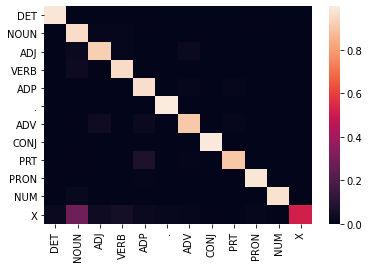

In [211]:
import seaborn as sn

sn.heatmap(conf)
plt.show()

## Rough Work

In [223]:
words = nltk.corpus.brown.tagged_words(tagset="universal")

In [228]:
xwords = {x for x,y in words if y=='X'}

In [230]:
{x[-2:] for x in xwords}

{"'s",
 "'t",
 '(',
 ')',
 '*0',
 ',',
 '-',
 '--',
 '-C',
 '0C',
 '29',
 '38',
 '7e',
 '8e',
 ':',
 '?',
 'A',
 'Ad',
 'Af',
 'Al',
 'C.',
 'De',
 'Du',
 'El',
 'En',
 'HS',
 'I',
 'IS',
 'Il',
 'LD',
 'La',
 'Le',
 'Ma',
 'Mi',
 'O',
 'OS',
 'Re',
 'S.',
 'Se',
 'T.',
 'Y',
 'a',
 'ad',
 'ae',
 'ah',
 'ai',
 'al',
 'am',
 'an',
 'ao',
 'ar',
 'as',
 'at',
 'au',
 'aw',
 'ax',
 'ay',
 'ba',
 'be',
 'by',
 'ca',
 'ce',
 'ch',
 'ci',
 'ck',
 'co',
 'cu',
 'da',
 'de',
 'di',
 'do',
 'ds',
 'du',
 'ea',
 'ec',
 'ed',
 'ee',
 'ef',
 'eh',
 'ei',
 'el',
 'em',
 'en',
 'er',
 'es',
 'et',
 'eu',
 'ex',
 'ez',
 'fe',
 'fo',
 'ft',
 'fu',
 'ge',
 'gi',
 'go',
 'ha',
 'he',
 'hi',
 'hr',
 'ht',
 'ia',
 'ic',
 'id',
 'ie',
 'if',
 'ij',
 'il',
 'im',
 'in',
 'io',
 'ir',
 'is',
 'it',
 'ix',
 'ja',
 'je',
 'ka',
 'ke',
 'ko',
 'kt',
 'ku',
 "l'",
 'l.',
 'la',
 'ld',
 'le',
 'li',
 'ln',
 'lo',
 'ls',
 'lu',
 'ly',
 'ma',
 'me',
 'mi',
 'mo',
 'mp',
 'mt',
 'n.',
 'na',
 'nd',
 'ne',
 'ng',
 'n

In [40]:
z = pd.Series(np.zeros(len(y)), index=y.index)

In [46]:
z = pd.Series([5,6])

In [47]:
y = pd.Series([3,5])
y*z

0    15
1    30
dtype: int64

In [49]:
y.index = ['a', 'b']

In [51]:
y.idxmax()

'b'

In [107]:
x=pd.Series({'a':1,'b':2})

In [108]:
df[df!=1]-x


,a,b
a,NaN,-1.840000
b,NaN,-1.857143


In [106]:
x

,a,b
a,0.2,0.040000
b,0.8,0.571429
